In [3]:
def remove_parentheses(ss):
    ss = np.array(ss)
    for i in range(ss.size):
        s = ss[i].split('(')
        s = s[0]
        ss[i] = s
    return ss

In [4]:
import numpy as np
import pandas as pd
def bootstrap(x, n_boot):
    n = x.shape[0]
    mean = np.array([np.nanmean(x,axis=0)])
    for i in range(n_boot-1):
        inds = np.random.choice(np.arange(n), size=n, replace=True)
        xs = x[inds,:]
        mean = np.append(mean, np.array([np.nanmean(xs,axis=0)]), axis=0)
    return np.median(mean,axis=0), np.percentile(mean, 2.5, axis=0), np.percentile(mean, 97.5, axis=0)

In [5]:
# Visualizes the location visit durations across different demographic (e.g., emplotyment) and mental health (e.g. depression)
# groups

import pickle
import os
import numpy as np
import pandas as pd

ft_dir = 'features_long/'

# list feature files
files = os.listdir(ft_dir)
# files = [files[0]]

# reading top locations
with open('top_locations.dat') as f:
    location_top = pickle.load(f)
f.close()

# reading assessments
with open('../Assessment/assessment.dat') as f:
    data = pickle.load(f)
f.close()

# reading demographics
with open('../Demographics/demo.dat') as f:
    demo = pickle.load(f)
f.close()

# adding demo to dataframe
data.insert(loc=len(data.columns), column='gender', value=np.nan)
data.insert(loc=len(data.columns), column='age', value=np.nan)
data.insert(loc=len(data.columns), column='employment', value=np.nan)

for (i,subj) in enumerate(data['ID']):
    ind = np.where(demo['ID']==subj)[0][0]
    data.loc[i,'gender'] = demo.loc[ind, 'gender']
    data.loc[i,'age'] = demo.loc[ind, 'age']
    data.loc[i,'employment'] = demo.loc[ind, 'employment']

# adding durations to dataframes
for loc_top in location_top:
    data.insert(loc=len(data.columns), column=loc_top, value=np.nan)

# for filename in files:
#     with open(ft_dir+filename) as f:  
#         feature, target = pickle.load(f)
#         ind_subject = np.where(data['ID']==filename[:-4])[0][0]
#         data.loc[ind_subject, location_top] = 0
#         dur_all = 0
#         for (i,loc) in enumerate(target['location']):
#             if not np.isnan(feature['n gps'][i]):
#                 if loc in location_top:
#                     data.loc[ind_subject, loc] += feature['n gps'][i]
#                 dur_all += feature['n gps'][i]
#         data.loc[ind_subject, location_top] /= dur_all #normalize
#     f.close()

folders = os.listdir('data/')
for fol in folders:
    ind_subject = np.where(data['ID']==fol)[0][0]
    subfolders = os.listdir('data/'+fol)
    data.loc[ind_subject, location_top] = 0
    dur_all = 0
#     tmin=np.inf
#     tmax=-np.inf
    for subf in subfolders:
        file_eml = 'data/'+fol+'/'+subf+'/eml.csv'
        file_fus = 'data/'+fol+'/'+subf+'/fus.csv'
        if os.path.exists(file_eml) and os.path.exists(file_fus):
            df = pd.read_csv(file_eml, sep='\t', header=None)
            loc = df.loc[0,6][2:-2]
            df = pd.read_csv(file_fus, sep='\t', header=None)
            t = np.array(df.loc[:,0])
            tdiff = t[1:]-t[:-1]
            tdiff = tdiff[tdiff<600]
            dur = np.sum(tdiff)
#             if tmin>df.loc[0,0]:
#                 tmin = df.loc[0,0]
#             if tmax<df.loc[df.shape[0]-1,0]:
#                 tmax = df.loc[df.shape[0]-1,0]

            if loc in location_top:
                data.loc[ind_subject, loc] += dur
            dur_all += dur
#         else:
#             print 'no data for subject {} instance {}'.format(fol, subf)
#     data.loc[ind_subject, location_top] /= ((tmax-tmin)/86400.0) #normalize
    data.loc[ind_subject, location_top] /= dur_all #normalize


# Overall Distribution

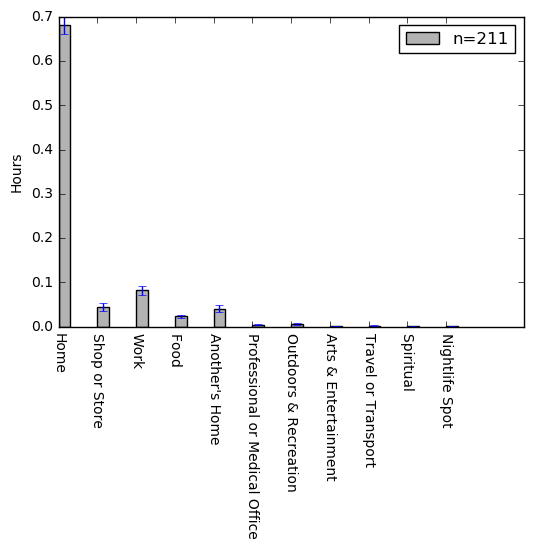

In [399]:
# all subjects

import matplotlib.pyplot as plt
%matplotlib inline

data_loc = data.loc[:,location_top]
mean = np.mean(data_loc, axis=0)
ci = np.std(data_loc, axis=0)/np.sqrt(data_loc.shape[0])

plt.bar(np.arange(mean.size), mean, yerr=ci, width=.3, color=(0.7,0.7,0.7))
plt.xticks(np.arange(mean.size), remove_parentheses(data_loc.columns), rotation=270)
plt.legend(['n={}'.format(data_loc.shape[0])])
plt.ylabel('Hours')

# Depression (PHQ-9)

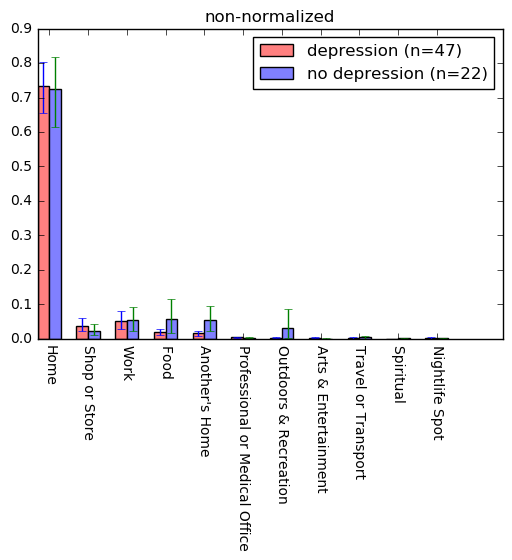

In [6]:
# PHQ-9

import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
%matplotlib inline

# option 1: all <> 10
# ind_dep = np.where(np.logical_and(np.logical_and(data['PHQ9 W0']>=10, data['PHQ9 W3']>=10), data['PHQ9 W6']>=10))[0]
# ind_nodep = np.where(np.logical_and(np.logical_and(data['PHQ9 W0']<10, data['PHQ9 W3']<10), data['PHQ9 W6']<10))[0]

# option 2: average <> 10
# ind_dep = np.where(data['PHQ9 W0']+data['PHQ9 W3']+data['PHQ9 W6']>=30)[0]
# ind_nodep = np.where(data['PHQ9 W0']+data['PHQ9 W3']+data['PHQ9 W6']<30)[0]

# option 3: |change| <> 5
ind_dep = np.where(data['PHQ9 W6']-data['PHQ9 W0']>=5)[0]
ind_nodep = np.where(data['PHQ9 W6']-data['PHQ9 W0']<=-5)[0]

data_dep = data.loc[ind_dep, list(location_top)]
data_nodep = data.loc[ind_nodep, list(location_top)]
data_dep = data_dep.reset_index(drop=True)
data_nodep = data_nodep.reset_index(drop=True)

# data_dep = np.log(np.finfo(float).eps+data_dep)
# data_nodep = np.log(np.finfo(float).eps+data_nodep)

mean_dep, lo_dep, hi_dep = bootstrap(np.array(data_dep), 1000)
mean_nodep, lo_nodep, hi_nodep = bootstrap(np.array(data_nodep), 1000)

plt.bar(np.arange(mean_dep.size), mean_dep, yerr=np.array([mean_dep-lo_dep,hi_dep-mean_dep]), width=.3, color=(1,.5,.5))
plt.bar(np.arange(mean_nodep.size)+.3, mean_nodep, yerr=np.array([mean_nodep-lo_nodep,hi_nodep-mean_nodep]), width=.3, color=(.5,.5,1))
plt.xticks(np.arange(mean_dep.size)+.3, remove_parentheses(data_dep.columns), rotation=270)
plt.legend(['depression (n={})'.format(data_dep.shape[0]),'no depression (n={})'.format(data_nodep.shape[0])])
plt.title('non-normalized')


0.926091864109
0.283367435623
0.928109982693
0.155924101231
0.0619223426096
0.258265399735
0.267030418983
0.0664274307809
0.531784968674
0.208581490921
0.314056452952


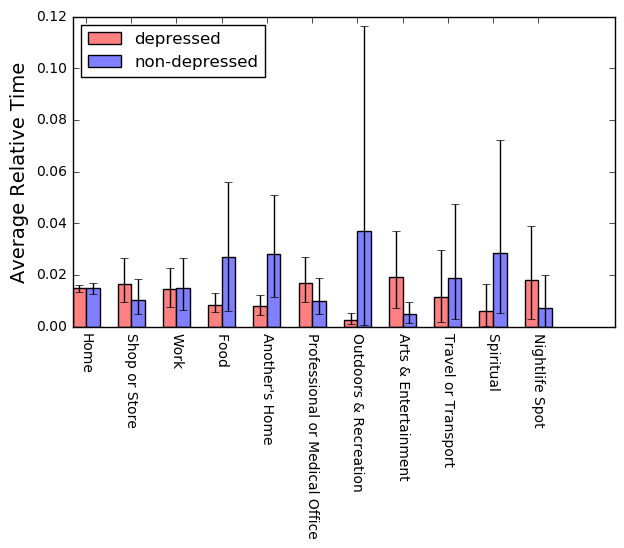

In [8]:
# same plot, normalized
plt.figure(figsize=[7,4])

persum = (np.sum(data_dep,axis=0)+np.sum(data_nodep,axis=0)).reshape([1,data_dep.shape[1]])
# persum = (np.mean(data_dep,axis=0)+np.mean(data_nodep,axis=0)).reshape([1,data_dep.shape[1]])

data_dep_norm = np.divide(data_dep, np.repeat(persum, data_dep.shape[0], axis=0))
data_nodep_norm = np.divide(data_nodep, np.repeat(persum, data_nodep.shape[0], axis=0))

mean_dep, lo_dep, hi_dep = bootstrap(np.array(data_dep_norm), 1000)
mean_nodep, lo_nodep, hi_nodep = bootstrap(np.array(data_nodep_norm), 1000)

plt.bar(np.arange(mean_dep.size), mean_dep, yerr=np.array([mean_dep-lo_dep,hi_dep-mean_dep]), width=.3, color=(1,.5,.5), ecolor=(0,0,0))
plt.bar(np.arange(mean_nodep.size)+.3, mean_nodep, yerr=np.array([mean_nodep-lo_nodep,hi_nodep-mean_nodep]), width=.3, color=(.5,.5,1),ecolor=(0,0,0))

# plt.legend(['depressed (n={})'.format(data_dep.shape[0]),'non-depressed (n={})'.format(data_nodep.shape[0])],loc='upper left')
plt.legend(['depressed','non-depressed'],loc='upper left')
plt.xticks(np.arange(mean_dep.size)+.3, remove_parentheses(data_dep.columns), rotation=270)
# plt.title('normalized')
plt.ylabel('Average Relative Time',fontsize=14)

# ttest
for (i,loc) in enumerate(location_top):
    _,p = ttest_ind(data_dep.loc[np.logical_not(np.isnan(data_dep.loc[:,loc])),loc], \
                    data_nodep.loc[np.logical_not(np.isnan(data_nodep.loc[:,loc])),loc], equal_var=False)
#     _,p = ranksums(data_dep.loc[np.logical_not(np.isnan(data_dep.loc[:,loc])),loc], \
#                     data_nodep.loc[np.logical_not(np.isnan(data_nodep.loc[:,loc])),loc])
    print p
    if p<.05:
        plt.plot(i+.3, max([hi_dep[i],hi_nodep[i]])+0.002, marker=(5,2), markersize=10, color=(0,0,0))

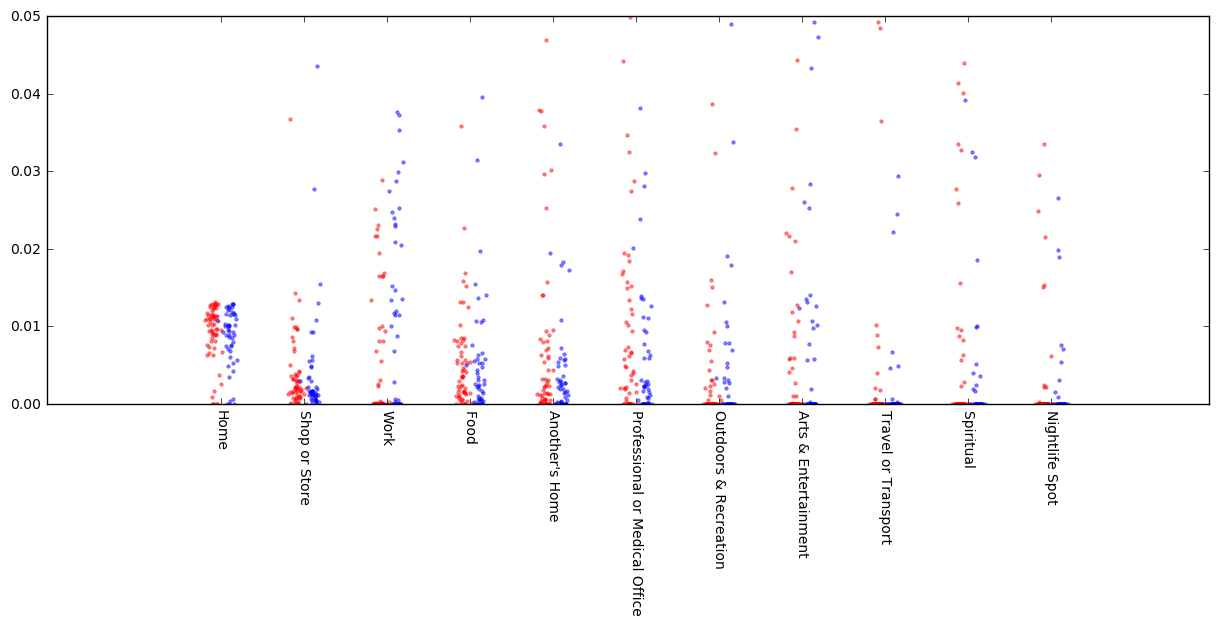

In [164]:
plt.figure(figsize=(15,5))
for i in range(data_dep_norm.shape[0]):
    plt.plot(np.arange(data_dep_norm.shape[1])+.05*np.random.normal(), data_dep_norm.loc[i,:], '.',color=(1,0,0), alpha=.5, markersize=5)
for i in range(data_nodep_norm.shape[0]):
    plt.plot(np.arange(data_nodep_norm.shape[1])+.05*np.random.normal()+.2, data_nodep_norm.loc[i,:], '.',color=(0,0,1), alpha=.5, markersize=5)
plt.ylim([0,0.05])
plt.xticks(np.arange(data_dep_norm.shape[1])+.1, remove_parentheses(data_dep_norm.columns), rotation=270);

# Anxiety (GAD-7)

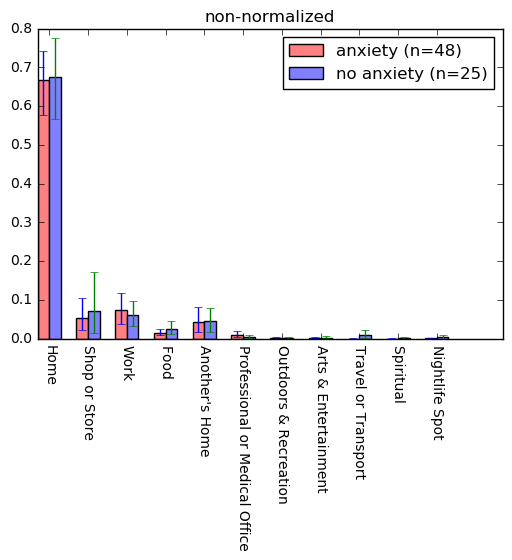

In [9]:
# compare anxious to non-anxious

import matplotlib.pyplot as plt
%matplotlib inline

# option 1: all <> 10
# ind_anx = np.where(np.logical_and(np.logical_and(data['GAD7 W0']>=10, data['GAD7 W3']>=10), data['GAD7 W6']>=10))[0]
# ind_noanx = np.where(np.logical_and(np.logical_and(data['GAD7 W0']<10, data['GAD7 W3']<10), data['GAD7 W6']<10))[0]

# option 2: average <> 10
# ind_anx = np.where(data['GAD7 W0']+data['GAD7 W3']+data['GAD7 W6']>=30)[0]
# ind_noanx = np.where(data['GAD7 W0']+data['GAD7 W3']+data['GAD7 W6']<30)[0]

# option 3: change <> 0
ind_anx = np.where(data['GAD7 W6']-data['GAD7 W0']>=5)[0]
ind_noanx = np.where(data['GAD7 W6']-data['GAD7 W0']<=-5)[0]

data_anx = data.loc[ind_anx, list(location_top)]
data_noanx = data.loc[ind_noanx, list(location_top)]

# mean_anx = np.mean(data_anx, axis=0)
# mean_noanx = np.mean(data_noanx, axis=0)
# ci_anx = np.std(data_anx, axis=0)/np.sqrt(data_anx.shape[0])
# ci_noanx = np.std(data_noanx, axis=0)/np.sqrt(data_noanx.shape[0])
mean_anx, lo_anx, hi_anx = bootstrap(np.array(data_anx), 1000)
mean_noanx, lo_noanx, hi_noanx = bootstrap(np.array(data_noanx), 1000)

plt.bar(np.arange(mean_anx.size), mean_anx, yerr=np.array([mean_anx-lo_anx,hi_anx-mean_anx]), width=.3, color=(1,0.5,0.5))
plt.bar(np.arange(mean_noanx.size)+.3, mean_noanx, yerr=np.array([mean_noanx-lo_noanx,hi_noanx-mean_noanx]), width=.3, color=(0.5,0.5,1))
plt.xticks(np.arange(mean_anx.size)+.3, remove_parentheses(data_anx.columns), rotation=270)
plt.legend(['anxiety (n={})'.format(data_anx.shape[0]),'no anxiety (n={})'.format(data_noanx.shape[0])])
plt.title('non-normalized')

0.933453228285
0.710401411578
0.62504196097
0.302941346432
0.955520858625
0.336737135571
0.868769501195
0.780174207908
0.121911879705
0.175901711008
0.327515069715


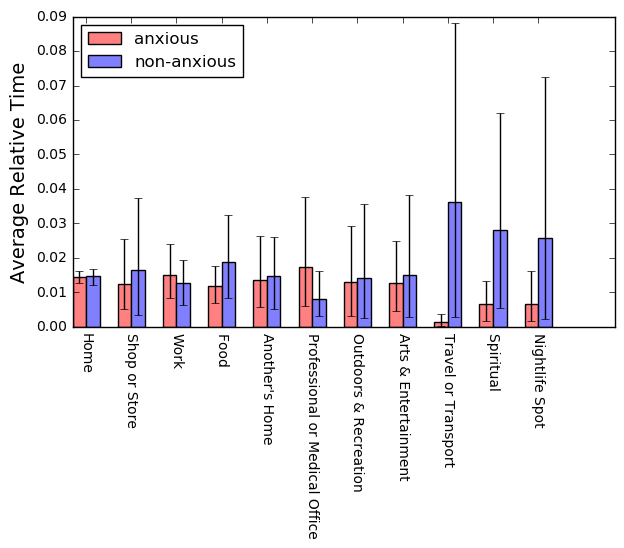

In [11]:
# same but normalized
plt.figure(figsize=[7,4])

# persum = mean_anx+mean_noanx
persum = (np.sum(data_anx,axis=0)+np.sum(data_noanx,axis=0)).reshape([1,data_anx.shape[1]])
data_anx_norm = np.divide(data_anx, np.repeat(persum, data_anx.shape[0], axis=0))
data_noanx_norm = np.divide(data_noanx, np.repeat(persum, data_noanx.shape[0], axis=0))
mean_anx, lo_anx, hi_anx = bootstrap(np.array(data_anx_norm), 1000)
mean_noanx, lo_noanx, hi_noanx = bootstrap(np.array(data_noanx_norm), 1000)

# plt.bar(np.arange(mean_anx.size), np.divide(mean_anx,persum), \
#         yerr=np.array([np.divide(mean_anx-lo_anx,persum),np.divide(hi_anx-mean_anx,persum)]), width=.3, color=(1,0.5,0.5))
# plt.bar(np.arange(mean_noanx.size)+.3, np.divide(mean_noanx,persum), \
#         yerr=np.array([np.divide(mean_noanx-lo_noanx,persum),np.divide(hi_noanx-mean_noanx,persum)]), width=.3, color=(0.5,0.5,1))

plt.bar(np.arange(mean_anx.size), mean_anx, yerr=np.array([mean_anx-lo_anx,hi_anx-mean_anx]), width=.3, color=(1,.5,.5), ecolor=(0,0,0))
plt.bar(np.arange(mean_noanx.size)+.3, mean_noanx, yerr=np.array([mean_noanx-lo_noanx,hi_noanx-mean_noanx]), width=.3, color=(.5,.5,1), ecolor=(0,0,0))

plt.xticks(np.arange(mean_anx.size)+.3, remove_parentheses(data_anx.columns), rotation=270)
# plt.legend(['anxiety (n={})'.format(data_anx.shape[0]),'no anxiety (n={})'.format(data_noanx.shape[0])],loc='upper left')
plt.legend(['anxious','non-anxious'],loc='upper left')
# plt.title('normalized')
plt.ylabel('Average Relative Time',fontsize=14)

for (i,loc) in enumerate(location_top):
    _,p = ttest_ind(data_anx.loc[np.logical_not(np.isnan(data_anx.loc[:,loc])),loc], \
                    data_noanx.loc[np.logical_not(np.isnan(data_noanx.loc[:,loc])),loc], equal_var=False)
#     _,p = ranksums(data_anx.loc[np.logical_not(np.isnan(data_anx.loc[:,loc])),loc], \
#                     data_noanx.loc[np.logical_not(np.isnan(data_noanx.loc[:,loc])),loc])
    print p
    if p<.05:
        plt.plot(i+.3, max([hi_anx[i],hi_noanx[i]])+0.002, marker=(5, 2), markersize=10, color=(0,0,0))


# Social Anxiety (SPIN)

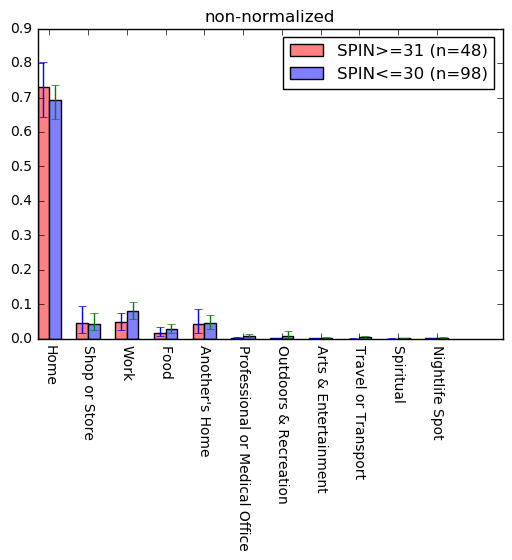

In [404]:
# SPIN

# option 1: all <> 31
ind_1 = np.where(np.logical_and(np.logical_and(data['SPIN W0']>=31, data['SPIN W3']>=31), data['SPIN W6']>=31))[0]
ind_0 = np.where(np.logical_and(np.logical_and(data['SPIN W0']<31, data['SPIN W3']<31), data['SPIN W6']<31))[0]

# option 2: average <> 10
# ind_dep = np.where(data['PHQ9 W0']+data['PHQ9 W3']+data['PHQ9 W6']>=30)[0]
# ind_nodep = np.where(data['PHQ9 W0']+data['PHQ9 W3']+data['PHQ9 W6']<30)[0]

# option 3: change <> 0
# ind_dep = np.where(data['PHQ9 W6']-data['PHQ9 W0']>5)[0]
# ind_nodep = np.where(data['PHQ9 W6']-data['PHQ9 W0']<-2)[0]

data_1 = data.loc[ind_1, list(location_top)]
data_0 = data.loc[ind_0, list(location_top)]
data_1 = data_1.reset_index(drop=True)
data_0 = data_0.reset_index(drop=True)

mean_1, lo_1, hi_1 = bootstrap(np.array(data_1), 1000)
mean_0, lo_0, hi_0 = bootstrap(np.array(data_0), 1000)

plt.bar(np.arange(mean_1.size), mean_1, yerr=np.array([mean_1-lo_1,hi_1-mean_1]), width=.3, color=(1,.5,.5))
plt.bar(np.arange(mean_0.size)+.3, mean_0, yerr=np.array([mean_0-lo_0,hi_0-mean_0]), width=.3, color=(.5,.5,1))
plt.xticks(np.arange(mean_1.size)+.3, remove_parentheses(data_1.columns), rotation=270)
plt.legend(['SPIN>=31 (n={})'.format(data_1.shape[0]),'SPIN<=30 (n={})'.format(data_0.shape[0])])
plt.title('non-normalized')


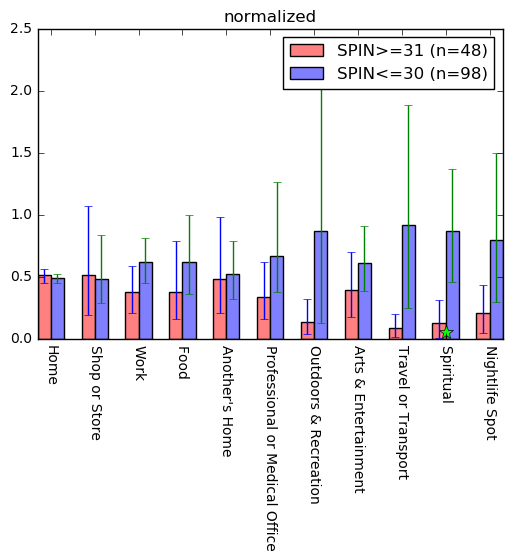

In [405]:
# same but normalized
from scipy.stats import ttest_ind,ranksums
persum = mean_1+mean_0
plt.bar(np.arange(mean_1.size), np.divide(mean_1,persum), \
        yerr=np.array([np.divide(mean_1-lo_1,persum),np.divide(hi_1-mean_1,persum)]), width=.3, color=(1,0.5,0.5))
plt.bar(np.arange(mean_0.size)+.3, np.divide(mean_0,persum), \
        yerr=np.array([np.divide(mean_0-lo_0,persum),np.divide(hi_0-mean_0,persum)]), width=.3, color=(0.5,0.5,1))
plt.xticks(np.arange(mean_1.size)+.3, remove_parentheses(data_1.columns), rotation=270)
plt.legend(['SPIN>=31 (n={})'.format(data_1.shape[0]),'SPIN<=30 (n={})'.format(data_0.shape[0])])
plt.title('normalized')

# ttest
for (i,loc) in enumerate(location_top):
    _,p = ttest_ind(data_1.loc[np.logical_not(np.isnan(data_1.loc[:,loc])),loc], \
                    data_0.loc[np.logical_not(np.isnan(data_0.loc[:,loc])),loc], equal_var=False)
#     _,p = ranksums(data_1.loc[np.logical_not(np.isnan(data_1.loc[:,loc])),loc], \
#                     data_0.loc[np.logical_not(np.isnan(data_0.loc[:,loc])),loc])
    if p<.05:
        plt.plot(i+.3, 0.05, '*', markersize=10, color=(0,1,0))

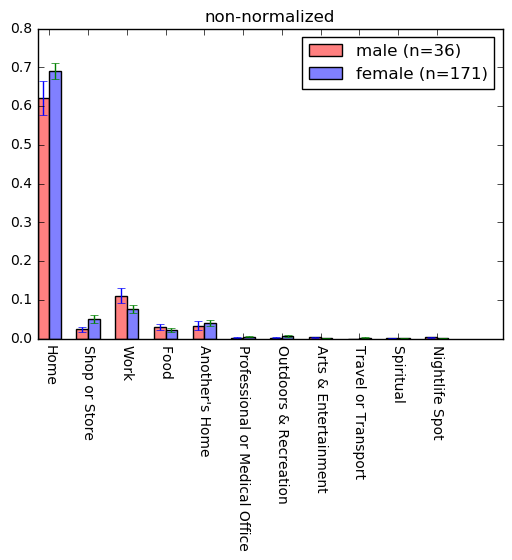

In [406]:
# gender

import matplotlib.pyplot as plt
%matplotlib inline

ind_male = np.where(data['gender']==1)[0]
ind_female = np.where(data['gender']==2)[0]

data_male = data.loc[ind_male, list(location_top)]
data_female = data.loc[ind_female, list(location_top)]

mean_male = np.mean(data_male, axis=0)
mean_female = np.mean(data_female, axis=0)
ci_male = np.std(data_male, axis=0)/np.sqrt(data_male.shape[0])
ci_female = np.std(data_female, axis=0)/np.sqrt(data_female.shape[0])

plt.bar(np.arange(mean_male.size), mean_male, yerr=ci_male, width=.3, color=(1,0.5,0.5))
plt.bar(np.arange(mean_female.size)+.3, mean_female, yerr=ci_female, width=.3, color=(0.5,0.5,1))
plt.xticks(np.arange(mean_male.size)+.3, remove_parentheses(data_male.columns), rotation=270)
plt.legend(['male (n={})'.format(data_male.shape[0]),'female (n={})'.format(data_female.shape[0])])
plt.title('non-normalized')

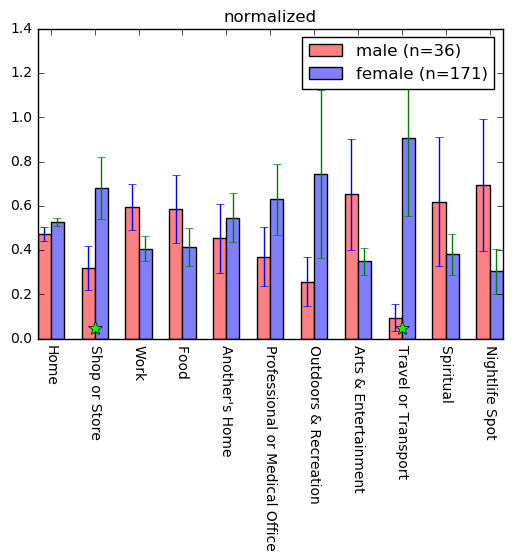

In [407]:
plt.bar(np.arange(mean_male.size), np.divide(mean_male,mean_male+mean_female), yerr=np.divide(ci_male,mean_male+mean_female), width=.3, color=(1,0.5,0.5))
plt.bar(np.arange(mean_female.size)+.3, np.divide(mean_female,mean_male+mean_female), yerr=np.divide(ci_female,mean_male+mean_female), width=.3, color=(0.5,0.5,1))
plt.xticks(np.arange(mean_male.size)+.3, remove_parentheses(data_anx.columns), rotation=270)
plt.legend(['male (n={})'.format(data_male.shape[0]),'female (n={})'.format(data_female.shape[0])])
plt.title('normalized')

# ttest
for (i,loc) in enumerate(location_top):
    _,p = ttest_ind(data_male.loc[np.logical_not(np.isnan(data_male.loc[:,loc])),loc], \
                    data_female.loc[np.logical_not(np.isnan(data_female.loc[:,loc])),loc], equal_var=False)
#     print p
    if p<.05:
        plt.plot(i+.3, 0.05, '*', markersize=10, color=(0,1,0))

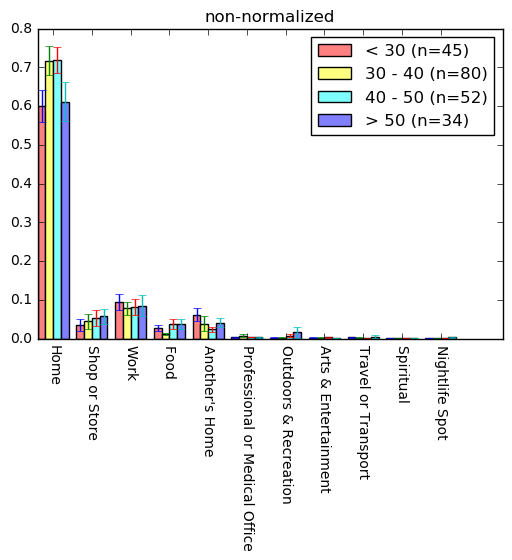

In [66]:
# age

import matplotlib.pyplot as plt
%matplotlib inline

ind_1 = np.where(data['age']<30)[0]
ind_2 = np.where(np.logical_and(data['age']>=30,data['age']<40))[0]
ind_3 = np.where(np.logical_and(data['age']>=40,data['age']<50))[0]
ind_4 = np.where(data['age']>50)[0]

data_1 = data.loc[ind_1, list(location_top)]
data_2 = data.loc[ind_2, list(location_top)]
data_3 = data.loc[ind_3, list(location_top)]
data_4 = data.loc[ind_4, list(location_top)]

mean_1 = np.mean(data_1, axis=0)
mean_2 = np.mean(data_2, axis=0)
mean_3 = np.mean(data_3, axis=0)
mean_4 = np.mean(data_4, axis=0)
ci_1 = np.std(data_1, axis=0)/np.sqrt(data_1.shape[0])
ci_2 = np.std(data_2, axis=0)/np.sqrt(data_1.shape[0])
ci_3 = np.std(data_3, axis=0)/np.sqrt(data_1.shape[0])
ci_4 = np.std(data_4, axis=0)/np.sqrt(data_1.shape[0])

plt.bar(np.arange(mean_1.size), mean_1, yerr=ci_1, width=.2, color=(1,0.5,0.5))
plt.bar(np.arange(mean_2.size)+.2, mean_2, yerr=ci_2, width=.2, color=(1,1,0.5))
plt.bar(np.arange(mean_3.size)+.4, mean_3, yerr=ci_3, width=.2, color=(0.5,1,1))
plt.bar(np.arange(mean_4.size)+.6, mean_4, yerr=ci_4, width=.2, color=(0.5,0.5,1))
plt.xticks(np.arange(mean_male.size)+.4, remove_parentheses(data_male.columns), rotation=270)
plt.legend(['< 30 (n={})'.format(data_1.shape[0]),'30 - 40 (n={})'.format(data_2.shape[0]),\
            '40 - 50 (n={})'.format(data_3.shape[0]), '> 50 (n={})'.format(data_4.shape[0])])
plt.title('non-normalized')

# plt.hist(data['age'])

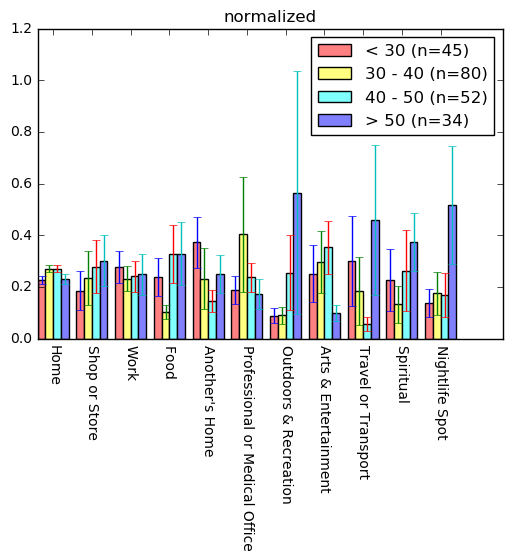

In [67]:
mean_all = mean_1+mean_2+mean_3+mean_4
plt.bar(np.arange(mean_1.size), np.divide(mean_1,mean_all), yerr=np.divide(ci_1,mean_all), width=.2, color=(1,0.5,0.5))
plt.bar(np.arange(mean_2.size)+.2, np.divide(mean_2,mean_all), yerr=np.divide(ci_2,mean_all), width=.2, color=(1,1,0.5))
plt.bar(np.arange(mean_3.size)+.4, np.divide(mean_3,mean_all), yerr=np.divide(ci_3,mean_all), width=.2, color=(0.5,1,1))
plt.bar(np.arange(mean_4.size)+.6, np.divide(mean_4,mean_all), yerr=np.divide(ci_4,mean_all), width=.2, color=(0.5,0.5,1))
plt.xticks(np.arange(mean_1.size)+.4, remove_parentheses(data_1.columns), rotation=270)
plt.legend(['< 30 (n={})'.format(data_1.shape[0]),'30 - 40 (n={})'.format(data_2.shape[0]),\
            '40 - 50 (n={})'.format(data_3.shape[0]), '> 50 (n={})'.format(data_4.shape[0])])
plt.title('normalized')

# ttest -- should change to anova
# for (i,loc) in enumerate(location_top):
#     _,p = ttest_ind(data_male.loc[np.logical_not(np.isnan(data_male.loc[:,loc])),loc], \
#                     data_female.loc[np.logical_not(np.isnan(data_female.loc[:,loc])),loc], equal_var=False)
#     print p
#     if p<.05:
#         plt.plot(i+.3, 0.05, '*', markersize=10, color=(0,1,0))